In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Explore Table Names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Explore Table Columns
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
#Explore Table Columns
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
ytd_precip = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(ytd_precip)


('2017-08-23',)


In [14]:
# Calculate the date 1 year ago from the last data point in the database
one_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(one_year)

2016-08-23


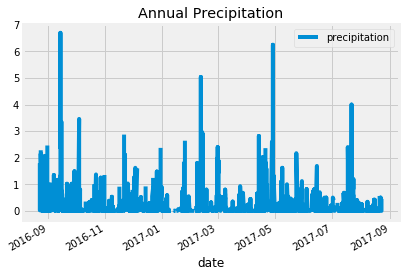

In [15]:
# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(data, columns = ["date", "precipitation"])
precip_df["date"] = pd.to_datetime(precip_df["date"], format = "%Y/%m/%d")
precip_df.set_index("date", inplace = True)

# Sort the dataframe by date
precip_df = precip_df.sort_values(by="date", ascending = True)
precip_df

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(title="Annual Precipitation")
plt.savefig("Images/Precipitation.png")
plt.legend(loc = "upper right")
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct().count()

9

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active = active_stations[0][0]
most_active

stats = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()
stats

[(54.0, 85.0, 71.66378066378067)]

In [20]:
# Choose the station with the highest number of temperature observations.
most_tobs = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
most_tobs = most_tobs[0]
most_tobs

'USC00519281'

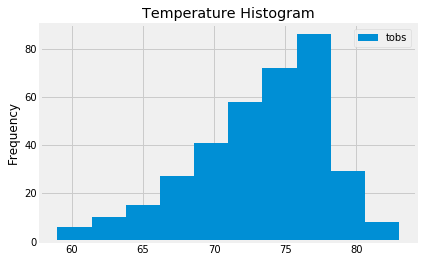

In [21]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_over_year = session.query(Measurement.tobs).filter(Measurement.date >= one_year).\
    filter(Measurement.station == most_tobs).all()

yearly_temp = pd.DataFrame(temp_over_year)

yearly_temp.plot.hist(bins=10, title = "Temperature Histogram")
plt.savefig("Images/Histogram.png")
plt.show()

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2012-02-28', '2012-03-05')
trip_temps

[(62.0, 69.57142857142857, 74.0)]

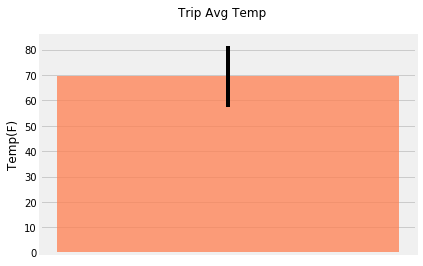

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_min = trip_temps[0][0]
trip_avg = trip_temps[0][1]
trip_max = trip_temps[0][2]

trip_dict = {'tmin':trip_temps[0][0],'tavg':trip_temps[0][1],'tmax':trip_temps[0][2]}
yerr = trip_max - trip_min

plt.bar(1, trip_avg, yerr=yerr, align='center', color='coral', alpha= .75)
plt.ylabel("Temp(F)")
plt.suptitle("Trip Avg Temp")
plt.xticks([])
plt.savefig("Images/TripAvgTemp.png")
plt.show()

In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# Join Measurement and Station Data
station_rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, Measurement.prcp).\
filter(Measurement.station==Station.station).\
filter(Measurement.date >='2012-02-28').\
filter(Measurement.date <= '2012-03-05').\
order_by(Measurement.prcp.desc()).all()

station_rainfall

[('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  6.24),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 5.71),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  5.37),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  4.68),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  2.71),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 2.7),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  2.0),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.1),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 1.08),
 ('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6,
  0.92),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  0.7),
 ('USC00516128',
  'MA

## Optional Challenge Assignment

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    normals = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*normals).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# Use the start and end date to create a range of dates
trip = pd.date_range('2012-02-28', '2012-03-05')

# Stip off the year and save a list of %m-%d strings
trip_md = trip.strftime("%m-%d")

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in trip_md:
    normals.append(*daily_normals(date))
    
normals

[(65.0, 70.65517241379311, 80.0),
 (67.0, 71.73333333333333, 79.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0)]

In [28]:
# Load the previous query results into a Pandas DataFrame 
normals_df = pd.DataFrame()
normals_df = pd.DataFrame(normals, index=trip, columns=[ 'tmin', 'tavg', 'tmax'])
normals_df.index.name = 'date'
normals_df

,tmin,tavg,tmax
date,,,
2012-02-28,65.0,70.655172,80.0
2012-02-29,67.0,71.733333,79.0
2012-03-01,64.0,70.032787,76.0
2012-03-02,61.0,70.366667,78.0
2012-03-03,60.0,70.068966,78.0
2012-03-04,57.0,69.272727,77.0
2012-03-05,60.0,67.890909,76.0


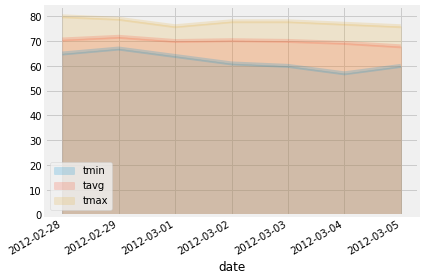

In [29]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', x_compat=True, alpha=.2, stacked=False)
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("Images/DailyNormals.png")